# **Importing Libraries**

In [ ]:
!pip install keras-tuner

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# **Data Collection-BTC**

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=700')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist.head(5)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1606608000,18347.24,17543.55,17739.90,27161.16,4.896800e+08,18199.23,direct,
1,1606694400,19850.23,18199.03,18199.23,77985.30,1.493788e+09,19686.87,direct,
2,1606780800,19911.79,18194.17,19686.87,91108.23,1.743191e+09,18792.03,direct,
3,1606867200,19337.16,18350.00,18792.03,47787.81,9.038178e+08,19226.19,direct,
4,1606953600,19608.49,18888.12,19226.19,38699.87,7.470888e+08,19448.44,direct,


# **Data Preprocessing**

In [ ]:
hist = hist.set_index('time')

hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)
hist.to_csv('LSTM_BTC.csv')

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

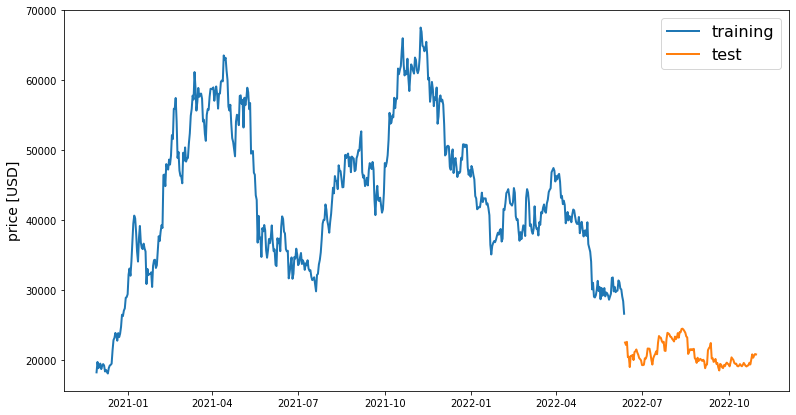

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

# **LSTM model**

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

NameError: ignored

In [ ]:
y_test_dummies = pd.get_dummies(y_test).values
# X_test_dummies = pd.get_dummies(X_test).values
scores=model.evaluate(X_test,y_test)
scores*100


5/5 [==============================] - 0s 4ms/step - loss: 8.7191e-04


0.08719059987924993

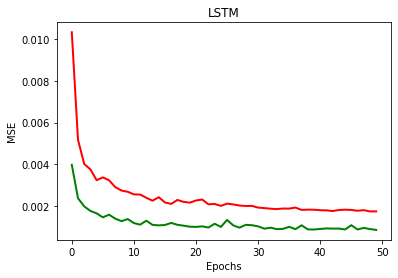

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)


5/5 [==============================] - 0s 5ms/step


0.021039235921528978

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0008719060238139198

In [ ]:
#MAPE
mape=np.mean(np.abs(np.array(preds)-np.array(X_test))/np.abs(X_test))
print('MAPE: '+ str(mape*100)+ '%')




ValueError: ignored

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7708776262061098

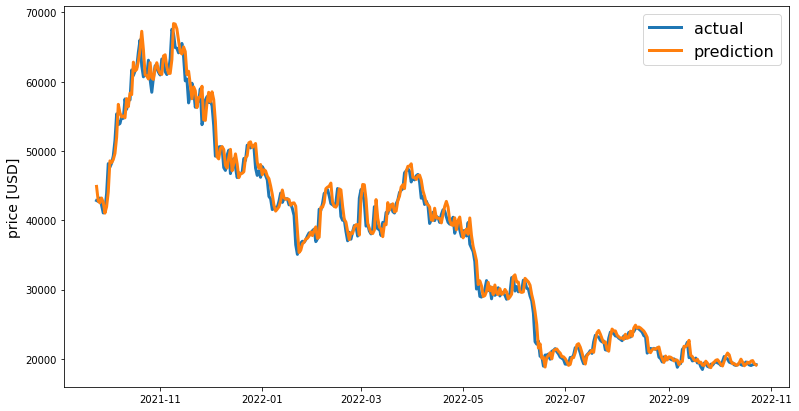

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **GRU model**

In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
def build_gru_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(tf.keras.layers.GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
gru_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

NameError: ignored

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_gru_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
50/50 [==============================] - 2s 11ms/step - loss: 0.0090 - val_loss: 0.0023
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 11/50
50/50 

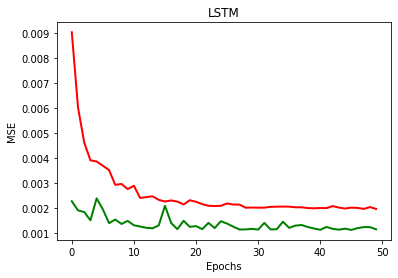

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 3ms/step


0.02463583076462018

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0011663682446074477

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7897480030773003

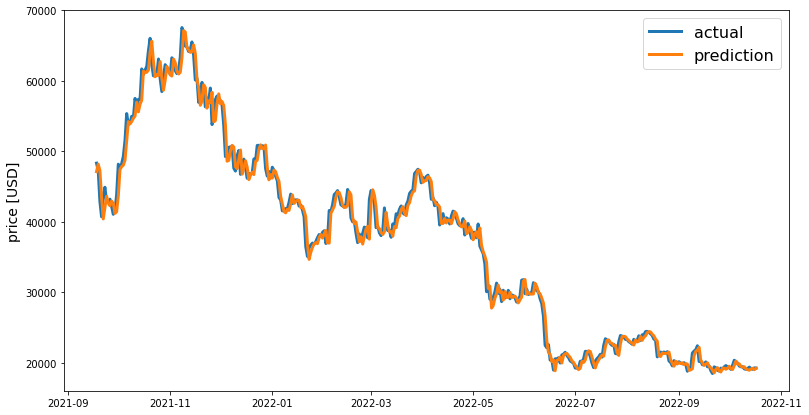

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **RNN model**

In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
def build_rnn_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(tf.keras.layers.SimpleRNN(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
gru_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_rnn_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 1s 9ms/step - loss: 0.0334 - val_loss: 0.0042
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0034
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0039
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 6/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0022
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 9/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 10/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 11/20
50/50 [

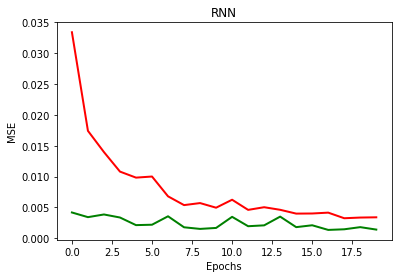

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('RNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 0s 2ms/step


0.028230902186836968

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0014175171445767413

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7495785413624821

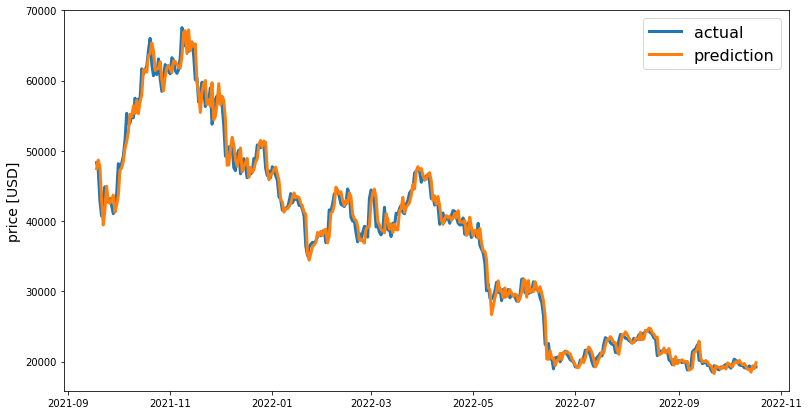

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **LSTM-GRU Hybrid Model**

In [ ]:
def build_lstm_gru_hybrid_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(LSTM(100,return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(tf.keras.layers.GRU(200,input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
gru_neurons = 50
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_gru_hybrid_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/80
50/50 [==============================] - 4s 27ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/80
50/50 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 5/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 10/80
50/50 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 11/

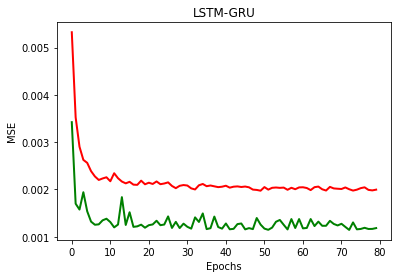

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM-GRU')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 5ms/step


0.02482702862123975

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0011830038748823616

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7867492293182071

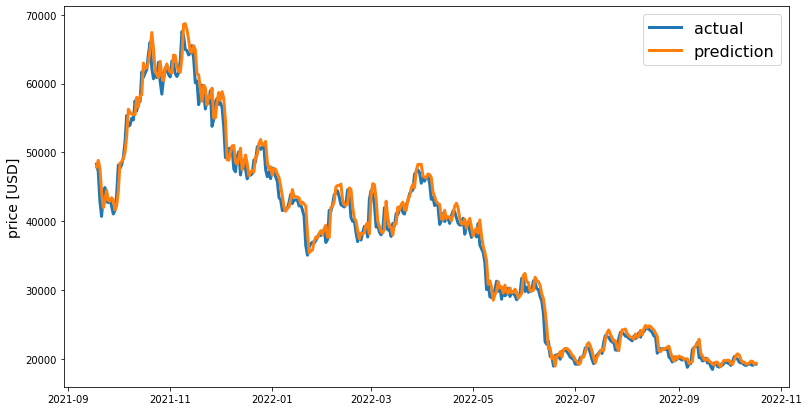

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **LSTM-RNN hybrid model**

In [ ]:
def build_lstm_rnn_hybrid_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(LSTM(100,return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(tf.keras.layers.SimpleRNN(50))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
gru_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_rnn_hybrid_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 6s 22ms/step - loss: 0.0092 - val_loss: 0.0025
Epoch 2/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 3/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 4/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 5/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 7/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 8/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 10/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 11/

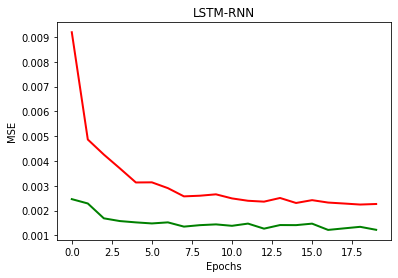

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM-RNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 3ms/step


0.025200620405609567

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0012285066635736356

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7829695169366856

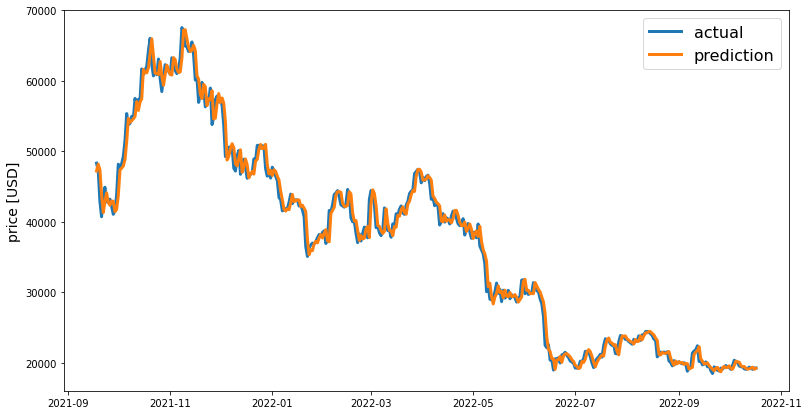

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **GRU-RNN hybrid model**

In [ ]:
def build_gru_rnn_hybrid_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(tf.keras.layers.GRU(200,return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(tf.keras.layers.SimpleRNN(50))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
gru_neurons = 200
rnn_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_gru_rnn_hybrid_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 4s 30ms/step - loss: 0.0154 - val_loss: 0.0025
Epoch 2/20
50/50 [==============================] - 1s 19ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 3/20
50/50 [==============================] - 1s 19ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 4/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 5/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 6/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 7/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 8/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 9/20
50/50 [==============================] - 1s 18ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 10/20
50/50 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 11/

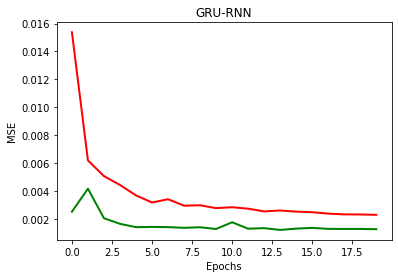

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('GRU-RNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 6ms/step


0.0260235183140525

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.001265025093967365

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.77651809683123

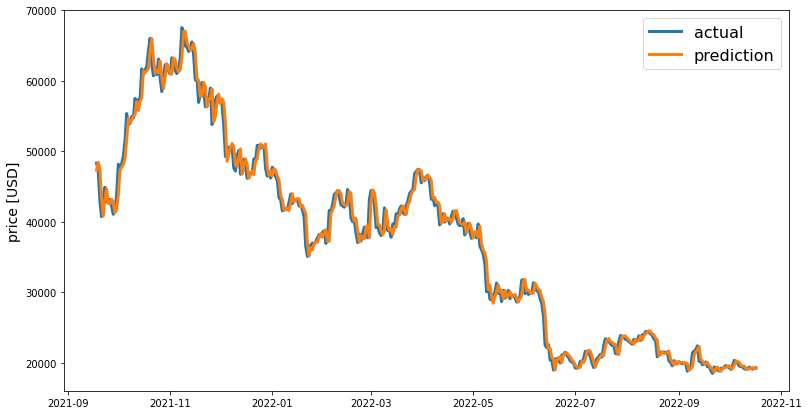

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

# **LSTM-GRU-RNN hybrid model**

In [ ]:
def build_lstm_gru_rnn_hybrid_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(LSTM(100,return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(tf.keras.layers.GRU(200,return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(tf.keras.layers.SimpleRNN(50))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
gru_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_gru_rnn_hybrid_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 7s 46ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 4/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 5/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 6/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/20
50/50 [==============================] - 1s 27ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/20
50/50 [==============================] - 1s 26ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 11/

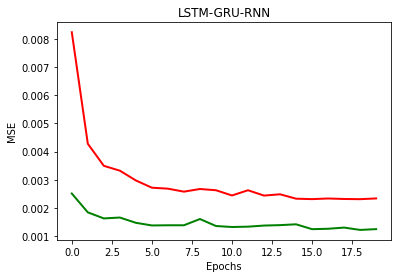

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM-GRU-RNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 8ms/step


0.025557972779246468

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0012430184838730786

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7804058292798727

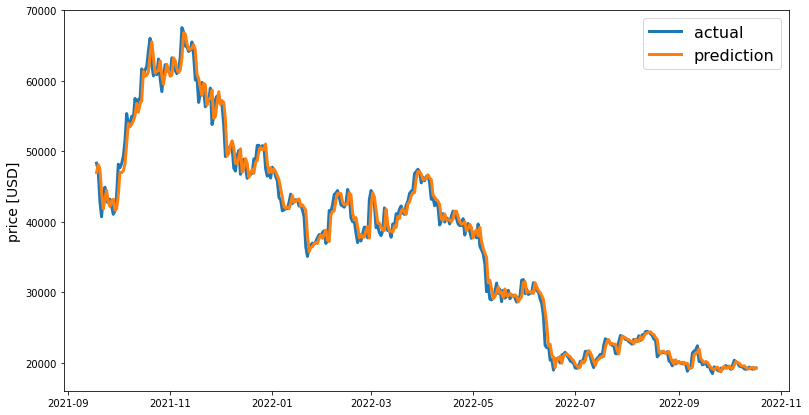

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)